<a href="https://colab.research.google.com/github/MohamedTheSobhy/Analyze-A-B-Test-Results/blob/main/BMW_sales_data_(2010_2024)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

import io, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
plt.rcParams['figure.figsize'] = (9,5)


uploaded = files.upload()
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print(df.shape); df.head()


Saving BMW sales data (2010-2024) (1).csv to BMW sales data (2010-2024) (1) (1).csv
(50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [8]:

overview = pd.DataFrame({
    "column": df.columns,
    "dtype": [df[c].dtype for c in df.columns],
    "non_null": [df[c].notna().sum() for c in df.columns],
    "missing": [df[c].isna().sum() for c in df.columns],
    "n_unique": [df[c].nunique() for c in df.columns],
})
overview


,column,dtype,non_null,missing,n_unique
0,Model,object,50000,0,11
1,Year,int64,50000,0,15
2,Region,object,50000,0,6
3,Color,object,50000,0,6
4,Fuel_Type,object,50000,0,4
5,Transmission,object,50000,0,2
6,Engine_Size_L,float64,50000,0,36
7,Mileage_KM,int64,50000,0,44347
8,Price_USD,int64,50000,0,38246
9,Sales_Volume,int64,50000,0,9845


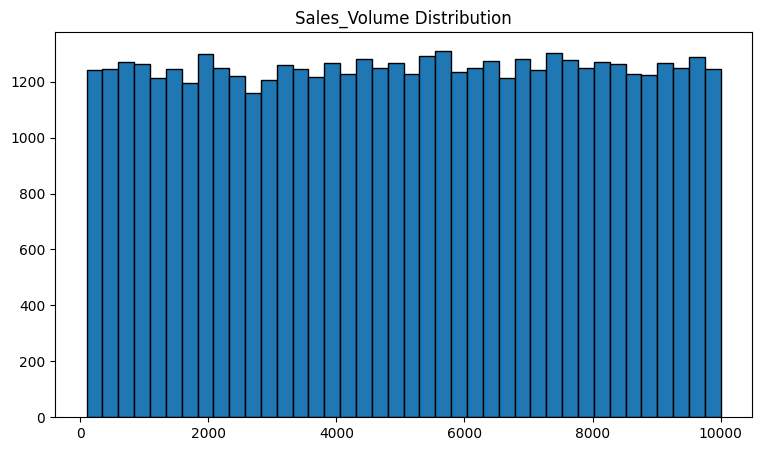

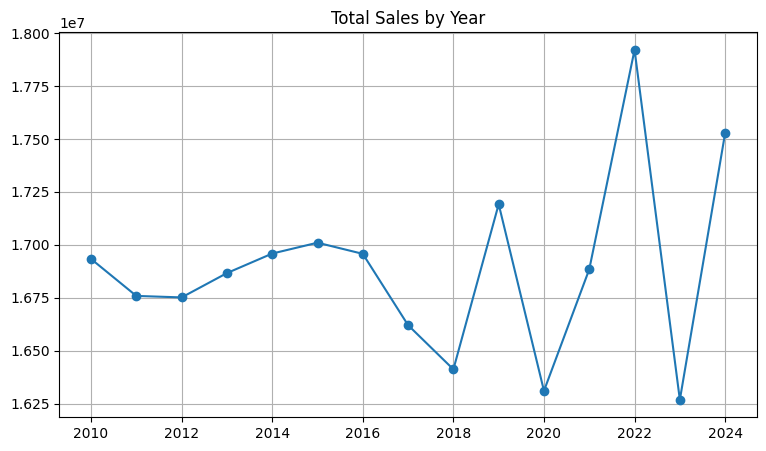

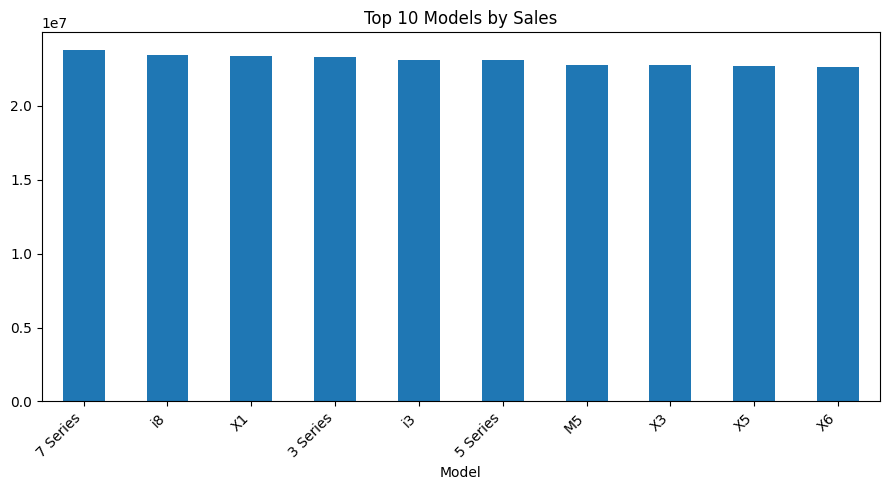

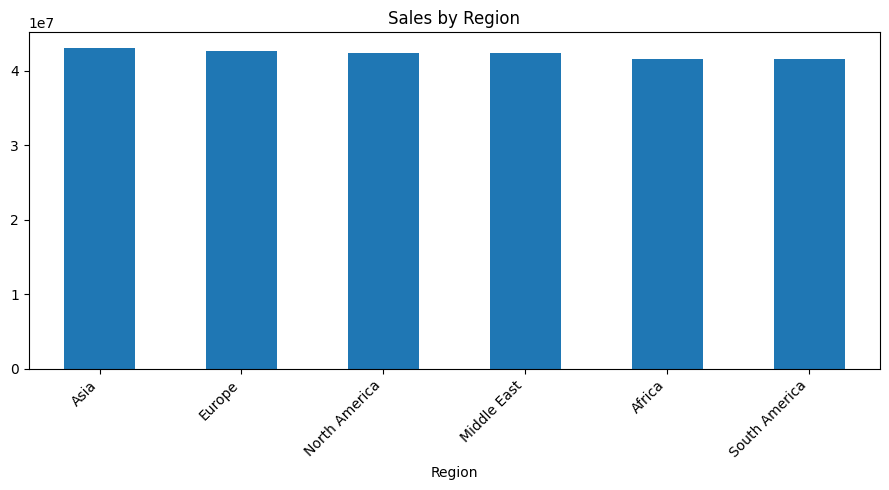

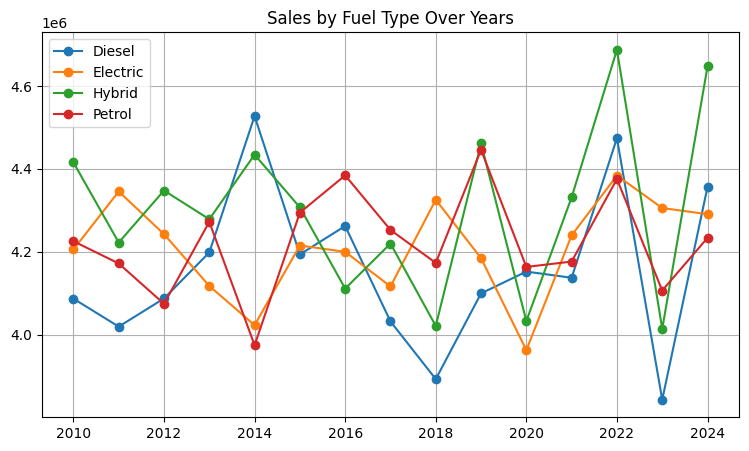

In [9]:

plt.hist(df["Sales_Volume"], bins=40, edgecolor="black"); plt.title("Sales_Volume Distribution"); plt.show()


yearly = df.groupby("Year")["Sales_Volume"].sum().reset_index()
plt.plot(yearly["Year"], yearly["Sales_Volume"], marker="o"); plt.title("Total Sales by Year"); plt.grid(True); plt.show()


top_models = (df.groupby("Model")["Sales_Volume"].sum().sort_values(ascending=False).head(10))
top_models.plot(kind="bar"); plt.title("Top 10 Models by Sales"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


region_sales = df.groupby("Region")["Sales_Volume"].sum().sort_values(ascending=False)
region_sales.plot(kind="bar"); plt.title("Sales by Region"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


fuel_year = df.pivot_table(index="Year", columns="Fuel_Type", values="Sales_Volume", aggfunc="sum").sort_index()
for col in fuel_year.columns: plt.plot(fuel_year.index, fuel_year[col], marker="o", label=str(col))
plt.title("Sales by Fuel Type Over Years"); plt.legend(); plt.grid(True); plt.show()


In [10]:
agg = (df.groupby(['Year','Model','Region','Fuel_Type'], as_index=False)
       .agg(Sales_Volume=('Sales_Volume','sum'),
            Avg_Price=('Price_USD','mean'),
            Avg_Engine=('Engine_Size_L','mean'),
            Avg_Mileage=('Mileage_KM','mean')))
agg.head(), agg.shape


(   Year     Model  Region Fuel_Type  Sales_Volume     Avg_Price  Avg_Engine  \
 0  2010  3 Series  Africa    Diesel         75456  83451.857143    2.914286   
 1  2010  3 Series  Africa  Electric         70404  83933.285714    3.635714   
 2  2010  3 Series  Africa    Hybrid        105241  77419.476190    3.223810   
 3  2010  3 Series  Africa    Petrol         56710  71822.909091    3.081818   
 4  2010  3 Series    Asia    Diesel         47431  63074.090909    3.418182   
 
      Avg_Mileage  
 0  109723.214286  
 1   77235.642857  
 2   90593.476190  
 3   99405.727273  
 4  104270.363636  ,
 (3960, 8))

In [11]:
unique_years = np.sort(agg['Year'].unique())
N_TEST_YEARS = 3
test_years = unique_years[-N_TEST_YEARS:]
train_years = unique_years[:-N_TEST_YEARS]

train = agg[agg['Year'].isin(train_years)].copy()
test  = agg[agg['Year'].isin(test_years)].copy()

y_train, y_test = train['Sales_Volume'], test['Sales_Volume']
X_train = train[['Year','Avg_Price','Avg_Engine','Avg_Mileage','Model','Region','Fuel_Type']]
X_test  = test[['Year','Avg_Price','Avg_Engine','Avg_Mileage','Model','Region','Fuel_Type']]

X_train.shape, X_test.shape, y_train.shape, y_test.shape, test_years


((3168, 7), (792, 7), (3168,), (792,), array([2022, 2023, 2024]))

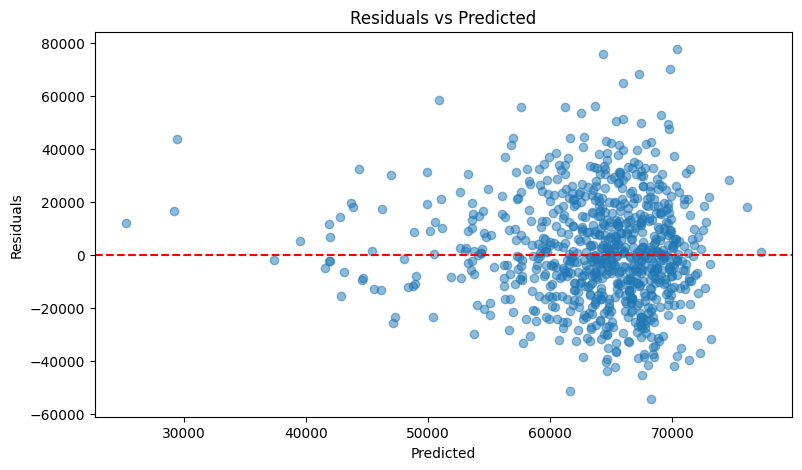

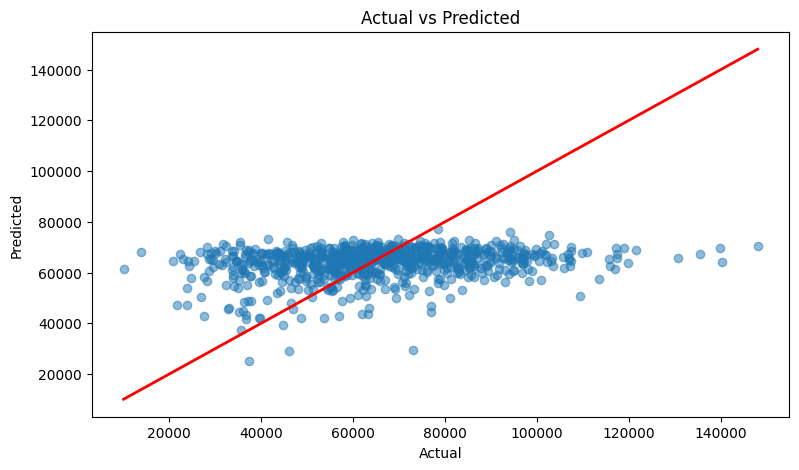

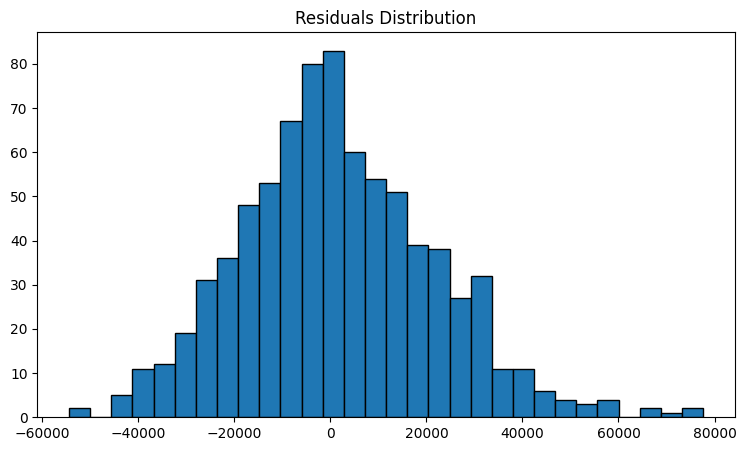

In [13]:
res = y_test.values - pred

# Residuals vs Predicted
plt.scatter(pred, res, alpha=0.5); plt.axhline(0, ls='--', c='r')
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Residuals vs Predicted"); plt.show()

# Actual vs Predicted
plt.scatter(y_test, pred, alpha=0.5)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn,mx],[mn,mx], 'r', lw=2)
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Actual vs Predicted"); plt.show()

# توزيع البواقي
plt.hist(res, bins=30, edgecolor='black'); plt.title("Residuals Distribution"); plt.show()


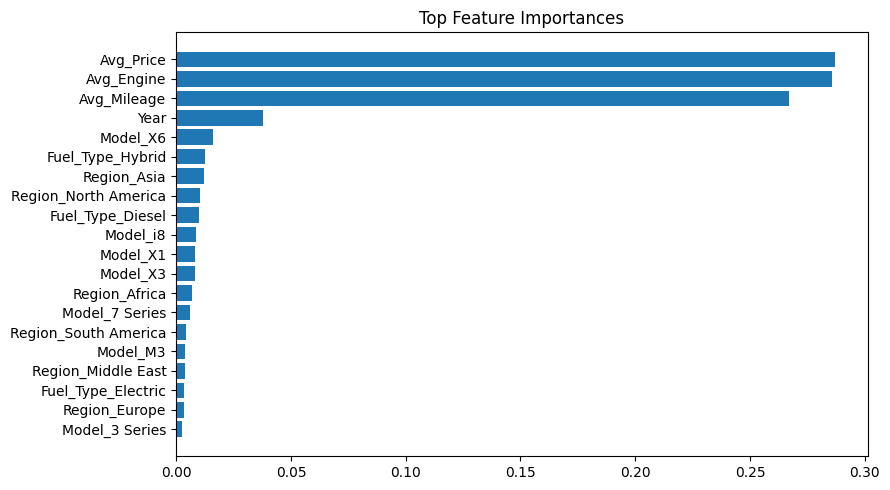

In [14]:
ohe = pipe.named_steps['pre'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_cols)
feat_names = np.r_[num_cols, cat_names]

importances = pipe.named_steps['model'].feature_importances_
idx = np.argsort(importances)[-20:]
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), feat_names[idx])
plt.title("Top Feature Importances"); plt.tight_layout(); plt.show()


In [15]:
from sklearn.model_selection import GroupKFold, cross_val_score
X_all = agg[['Year','Avg_Price','Avg_Engine','Avg_Mileage','Model','Region','Fuel_Type']]
y_all = agg['Sales_Volume']
groups = agg['Year']

cv = GroupKFold(n_splits=5)
scores = cross_val_score(pipe, X_all, y_all, cv=cv, groups=groups, scoring='r2')
print("CV R² per fold:", np.round(scores,4))
print("CV R² mean ±2std:", round(scores.mean(),4), "±", round(scores.std()*2,4))


CV R² per fold: [0.0714 0.0545 0.0659 0.0633 0.0744]
CV R² mean ±2std: 0.0659 ± 0.0138


In [16]:

scenarios = pd.DataFrame({
    'Year':[2024,2024],
    'Avg_Price':[60000,80000],
    'Avg_Engine':[2.0,3.0],
    'Avg_Mileage':[50000,80000],
    'Model':['3 Series','X5'],
    'Region':['Europe','Asia'],
    'Fuel_Type':['Hybrid','Petrol']
})
scenarios["Predicted_Sales"] = pipe.predict(scenarios)
scenarios

import joblib
joblib.dump(pipe, "bmw_sales_gbr_pipeline.pkl")


['bmw_sales_gbr_pipeline.pkl']

In [17]:
from sklearn.model_selection import GroupKFold, cross_val_score
import numpy as np

X_all = agg[['Year','Avg_Price','Avg_Engine','Avg_Mileage','Model','Region','Fuel_Type']]
y_all = agg['Sales_Volume']
groups = agg['Year']

cv = GroupKFold(n_splits=5)
cv_scores = cross_val_score(pipe, X_all, y_all, cv=cv, groups=groups, scoring='r2')
print("CV R² per fold:", np.round(cv_scores,4))
print("CV R² mean ± 2std:", round(cv_scores.mean(),4), "±", round(cv_scores.std()*2,4))


CV R² per fold: [0.0714 0.0545 0.0659 0.0633 0.0744]
CV R² mean ± 2std: 0.0659 ± 0.0138


In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    "model__n_estimators": randint(150, 600),
    "model__max_depth": randint(2, 6),
    "model__learning_rate": uniform(0.01, 0.2),
    "model__subsample": uniform(0.6, 0.4),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 20)
}

rand = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=40,
    cv=GroupKFold(5),
    random_state=42,
    n_jobs=-1,
    scoring="r2",
    verbose=1
)

rand.fit(X_all, y_all, groups=groups)
print("Best R²:", rand.best_score_)
print("Best params:", rand.best_params_)

best_pipe = rand.best_estimator_
joblib.dump(best_pipe, "bmw_sales_gbr_pipeline_tuned.pkl")


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best R²: 0.07397600756411042
Best params: {'model__learning_rate': np.float64(0.013193250444042839), 'model__max_depth': 3, 'model__min_samples_leaf': 15, 'model__min_samples_split': 8, 'model__n_estimators': 577, 'model__subsample': np.float64(0.798070764044508)}


['bmw_sales_gbr_pipeline_tuned.pkl']

In [19]:
import pandas as pd
pred_test = best_pipe.predict(X_test) if 'best_pipe' in globals() else pipe.predict(X_test)
test_eval = X_test.copy()
test_eval['Actual'] = y_test.values
test_eval['Pred'] = pred_test
test_eval['Residual'] = test_eval['Actual'] - test_eval['Pred']

print("Top Under-predictions:")
print(test_eval.sort_values('Residual').head(10)[['Year','Model','Region','Fuel_Type','Actual','Pred','Residual']])
print("\nTop Over-predictions:")
print(test_eval.sort_values('Residual', ascending=False).head(10)[['Year','Model','Region','Fuel_Type','Actual','Pred','Residual']])

seg_cols = ['Year','Region','Model','Fuel_Type']
for c in seg_cols:
    seg = test_eval.groupby(c)['Residual'].agg(['mean','median','std','count']).sort_values('mean')
    print(f"\nResiduals by {c}:\n", seg.head(10))


Top Under-predictions:
      Year     Model         Region Fuel_Type  Actual          Pred  \
3527  2023        M3  South America    Petrol   13787  65969.321971   
3333  2022        X3  South America  Electric   22275  71092.270845   
3611  2023        X5         Europe    Petrol   10054  58815.883668   
3482  2023  7 Series         Africa    Hybrid   20869  62809.095991   
3672  2023        i8         Africa    Diesel   26621  66102.943345   
3917  2024        i3           Asia  Electric   33642  72311.974363   
3368  2022        X6         Europe    Diesel   28232  66880.736391   
3654  2023        i3           Asia    Hybrid   25308  63687.165356   
3757  2024  7 Series    Middle East  Electric   24236  62546.887239   
3429  2022        i8  South America  Electric   28163  66296.240590   

          Residual  
3527 -52182.321971  
3333 -48817.270845  
3611 -48761.883668  
3482 -41940.095991  
3672 -39481.943345  
3917 -38669.974363  
3368 -38648.736391  
3654 -38379.165356  
3757 -

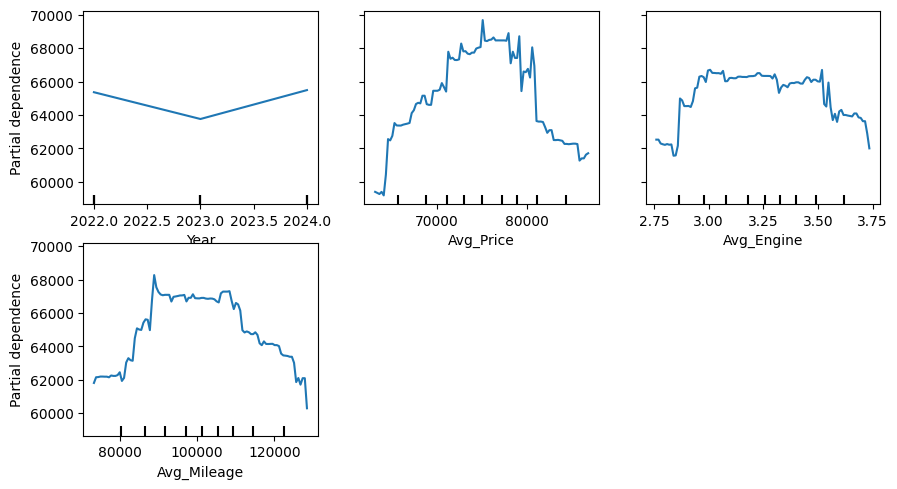

In [20]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

use_model = best_pipe if 'best_pipe' in globals() else pipe
fig1 = PartialDependenceDisplay.from_estimator(
    use_model, X_test,
    features=['Year','Avg_Price','Avg_Engine','Avg_Mileage'],
)
plt.tight_layout(); plt.show()


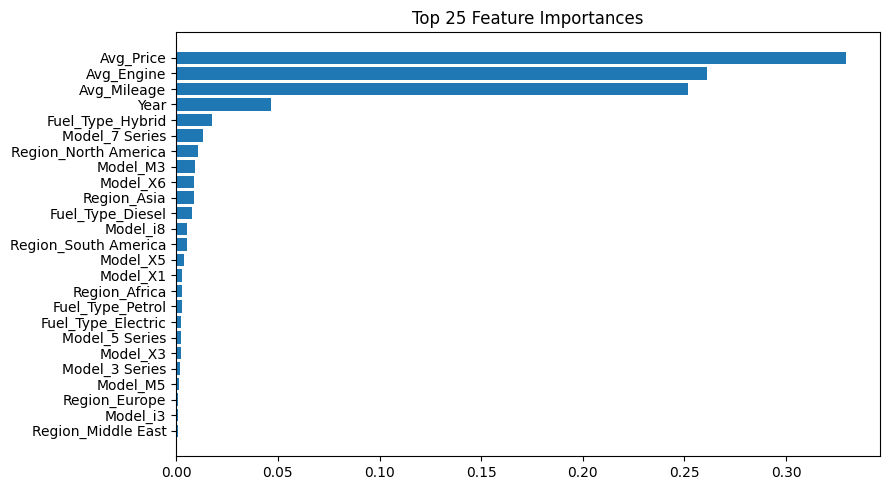

In [21]:
import numpy as np
import matplotlib.pyplot as plt

mdl = use_model.named_steps['model']
ohe = use_model.named_steps['pre'].named_transformers_['cat']
cat_cols = ['Model','Region','Fuel_Type']
cat_names = ohe.get_feature_names_out(cat_cols)
feat_names = np.r_[ ['Year','Avg_Price','Avg_Engine','Avg_Mileage'], cat_names ]

imp = mdl.feature_importances_
idx = np.argsort(imp)[-25:]

plt.barh(range(len(idx)), imp[idx])
plt.yticks(range(len(idx)), feat_names[idx])
plt.title("Top 25 Feature Importances")
plt.tight_layout(); plt.show()


In [22]:
more = pd.DataFrame({
    'Year':[2024,2024,2023,2022],
    'Avg_Price':[50000,70000,60000,80000],
    'Avg_Engine':[2.0,3.0,2.5,4.0],
    'Avg_Mileage':[60000,80000,40000,90000],
    'Model':['3 Series','X5','X3','5 Series'],
    'Region':['Europe','Asia','North America','Middle East'],
    'Fuel_Type':['Hybrid','Petrol','Diesel','Electric']
})
more['Pred'] = use_model.predict(more)
more

base = more.iloc[[0]].copy()
step = 2000
up = base.copy();  up['Avg_Price'] += step
down = base.copy(); down['Avg_Price'] -= step
pred_base = use_model.predict(base)[0]
pred_up   = use_model.predict(up)[0]
pred_down = use_model.predict(down)[0]
elasticity = ((pred_up - pred_down) / (2*step)) * (base['Avg_Price'].iloc[0] / pred_base)
print("Approx. price elasticity around scenario[0]:", float(elasticity))


Approx. price elasticity around scenario[0]: 0.0


In [23]:
joblib.dump(use_model, "bmw_sales_best_pipeline.pkl")
# loaded = joblib.load("bmw_sales_best_pipeline.pkl")
# loaded.predict(scenarios)


['bmw_sales_best_pipeline.pkl']